In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [84]:
def to_seconds(str):
        splitted=str.split(':')
        return (int(splitted[0])*3600+int(splitted[1])*60+int(splitted[2]))

def string_split(str):
    a=str.split('/')
    day,month,year=int(a[0]),int(a[1]),int(a[2])
    return datetime.datetime(day=day,month=month,year=2000+year)

def month(str):
        month=str.split('/')[1]
        months={1:'January',2:'Feburary',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
        return months[int(month)]

def indexDates(date):
    return (date.split('/'))[0]

In [85]:
class Data:
    #This is the main dataFrame or the parent Dataframe
    df=pd.DataFrame({})
    #This is the child dataFrame derived from the first one.
    df2=pd.DataFrame({})
    MileageArray=np.array([])
    #For storing the average speeds of the given data
    Speeds=np.array([])
    #For storing all the unique dates in the given data
    dates=np.array([])
    
    odo={}
     #In the constructor we are doing all the precalculations like:
    '''
        1. Sorting the data according to date and time
        2. Reseting the indices after the sorting
        3. Defining the Energy Column
        4. Defining the Energy Consumed Column
        5. Identifying all the unique dates and storing it in 'dates'.
    '''
    def __init__(self,dataframe):
        self.df=dataframe
        

        '''Here we are sorting the data on the basis of both date and time'''
        self.df['DateModified']=self.df['date'].map(string_split)
        self.df['Time_seconds']=self.df['time'].map(to_seconds)
        self.df.sort_values(['DateModified','Time_seconds'],inplace=True)
        
        #The distance needs to be calculated before we filter the data.
        self.CalDistance()
        #self.filterData()
        
        self.df.reset_index(inplace=True,drop=True)
        
        
        self.df['Energy_Wh']=(self.df['cummulativeDischarge']*self.df['batVolt'])/1000
        self.df['EnergyConsumed']=(self.df['Energy_Wh']).diff(1).fillna(np.nan)
        
        
        self.df['Month']=self.df['date'].map(month) 
        self.df2=self.df.drop(self.df.loc[self.df['EnergyConsumed']<=0].index)
        
        self.dates=self.df['date'].unique()
        self.CalTimeDifference()
    
    # def CalEnergy(self):
    #     for i in self.dates:
    #         self.df['Energy_Wh']=
    #Here in this function we are calculating the Time Difference between the columns of the function.
    def CalTimeDifference(self):
        for i in self.dates:
            self.df.loc[self.df['date']==i,'TimeDifference']=(self.df.loc[self.df['date']==i,'Time_seconds']-(self.df.loc[self.df['date']==i,'Time_seconds'].shift(1).fillna(0)))
    #In this function we are filtering the data on the basis of the zero current values.
    def filterData(self):
        self.df.drop(self.df.loc[(self.df['batCurrent']==0)&(self.df['speed']==0)].index,inplace=True)
    
    def trimArrays(self):
        sizeM=int(self.MileageArray.size)
        sizeS=int(self.Speeds.size)
        Minimum=(sizeM) if sizeM<=sizeS else sizeS
        print(Minimum)
        if(Minimum<sizeM):
            self.MileageArray=self.MileageArray[:-(sizeM-Minimum)]
        elif (Minimum<sizeS):
            self.Speeds=self.Speeds[:-(sizeS-Minimum)]
            
    def CalMileage(self):
        # dates=data.df2['date'].unique()
        #print(type(dates))
        # MileageArray=np.array([])
        #distance={}
        for i in self.dates:
            odo=self.df.loc[self.df['date']==i,'odo'].iloc[-1]-self.df.loc[self.df['date']==i,'odo'].iloc[0]
            #print(odo,end=", ")
            #distance[i]=odo
            if(odo>0):
                self.MileageArray=np.append(self.MileageArray,((self.df2.loc[self.df2['date']==i,'EnergyConsumed']).sum()/odo))
            self.df.loc[self.df['date']==i,'mileage']=(((self.df2.loc[self.df2['date']==i,'EnergyConsumed']).sum())/odo) if odo>0 else -1 
            #for not defined.
            
    def CalAverageSpeed(self):
        for i in self.dates:
            speed=self.df.loc[(self.df['date']==i)&(self.df['speed']!=0),'speed'].mean()
            if(speed>0):
                self.Speeds=np.append(self.Speeds,speed)
            self.df.loc[self.df['date']==i,'AverageSpeed_Kmph']=speed
    
    def CalDistance(self):
        for i in self.dates:
            self.odo[i]=self.df.loc[self.df['date']==i,'odo'].iloc[-1]-self.df.loc[self.df['date']==i,'odo'].iloc[0]

In [86]:
columns_to_pick=['date','time','speed','odo','batVolt','batCurrent','cummulativeCharge','cummulativeDischarge','chargeStatus','dischargeStatus']
df=pd.read_csv('1monthdata.csv',usecols=columns_to_pick)
#loading the one month data
OneMonth=Data(df)

In [87]:
max(OneMonth.df['speed'][df['date']=='02/02/23'])

48

<h3>Function for calculating the mileage for a given dataframe <b>df</b> and modified dataframe <b>df2</b></h3>

In [88]:
OneMonth.CalMileage()
OneMonth.MileageArray

array([ 14.91080278,  14.18066078,  14.46370074,  76.3542495 ,
        32.2289415 ,  13.68202262,  13.61638111,  13.67347707,
        11.2380139 ,  17.11228845,  22.66830467,  14.17972833,
        14.97751311,  15.37750294,  16.99555321,  11.52095049,
        12.51076856,  16.01724233,  22.1474355 ,  15.24381776,
        17.95714377,  11.21051476, 680.373762  ,  12.95308736,
        17.50353474])

In [89]:
indices=OneMonth.MileageArray[OneMonth.MileageArray==-1]
indices

array([], dtype=float64)

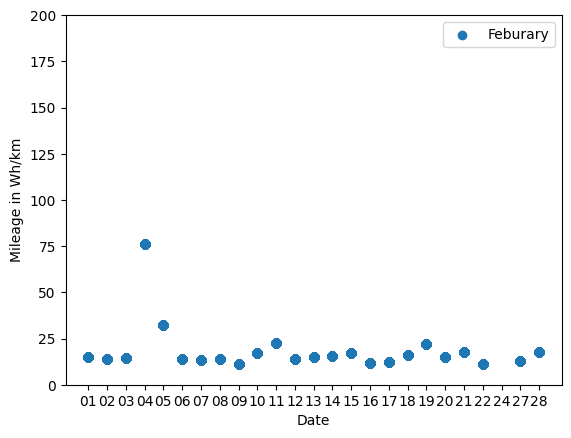

In [90]:
#df2.loc[df1['date']=='04/02/23','EnergyConsumed'].sum()
#df2['DateModified']=df2['date'].map(string_split)
for i in (OneMonth.df['Month'].unique()):
    plt.scatter(OneMonth.df['date'][(OneMonth.df['mileage']!=-1)&(OneMonth.df['Month']==i)].map(indexDates),OneMonth.df['mileage'][(OneMonth.df['mileage']!=-1)&(OneMonth.df['Month']==i)])
plt.ylim(0,200)
plt.ylabel('Mileage in Wh/km')
plt.xlabel('Date')
plt.legend(OneMonth.df['Month'].unique())

<h2>Correlation between mileage and speed
</h2>

In [91]:
OneMonth.CalAverageSpeed()
OneMonth.Speeds
OneMonth.trimArrays()

25


In [92]:
print(OneMonth.Speeds.size,OneMonth.MileageArray.size)

25 25


Text(0, 0.5, 'AverageSpeed in Kmph')

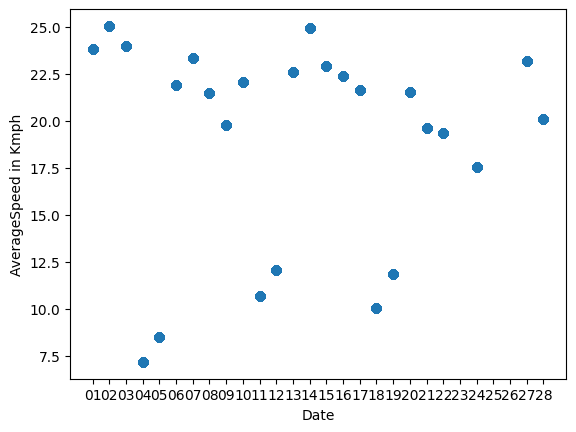

In [93]:
plt.scatter(OneMonth.df['date'].map(indexDates),OneMonth.df['AverageSpeed_Kmph'])
plt.xlabel('Date')
plt.ylabel('AverageSpeed in Kmph')

(0.0, 100.0)

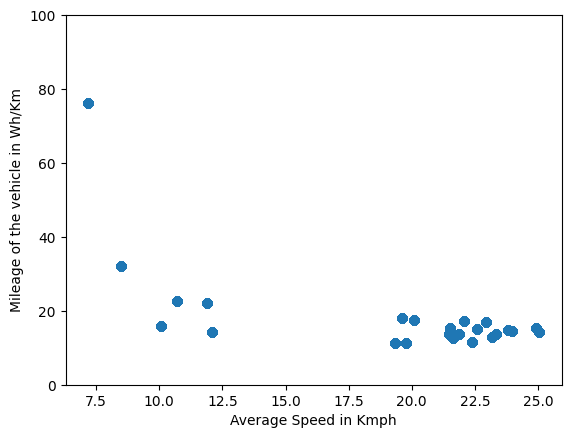

In [94]:
plt.scatter(OneMonth.df['AverageSpeed_Kmph'],OneMonth.df['mileage'])
plt.xlabel('Average Speed in Kmph')
plt.ylabel('Mileage of the vehicle in Wh/Km')
plt.ylim(0,100)

<h3>Function for find the mean squared error and printing the function</h3>

In [95]:
'''Function to calculate the mean squared error. 'true' is the actual value and 'pred' is the predicted value.'''
def mean_squared_error(true,pred):
    error=0
    for i in range(0,true.size):
        error+=(true[i]-pred[i])**2
    return error
def print_function(coff):
    for i in range(0,coff.size):
        print(coff[i],'x^',coff.size-i-1,end="+ ")

<h3>Finding the corelation between speed and mileage</h3>
<p>In this code below we are basically finding the <strong>best</strong> function of degree n for this we are checking the error value for each value of degree of the polynomial.</p>

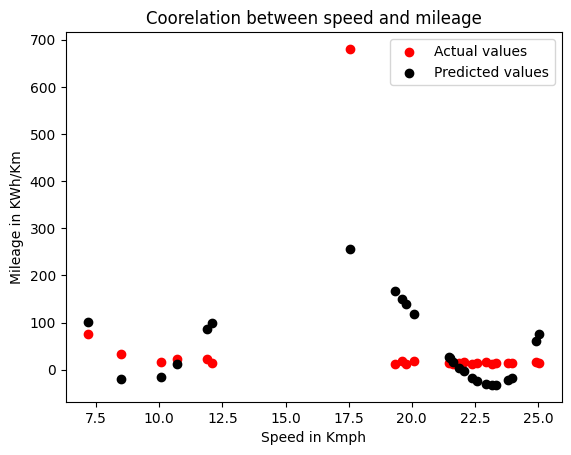

In [96]:
BestFitFunction={}# Dict(key=deg, value=[functionvalues])
minimum=0
deg=2
for i in range(2,5):
    z=np.polyfit(OneMonth.Speeds,OneMonth.MileageArray,deg=i)
    x=np.poly1d(z)
    y=np.array([])
    for j in OneMonth.Speeds:
        y=np.append(y,x(j))
    error=mean_squared_error(OneMonth.MileageArray,y)
    #print(error,end="*")
    match i:
        case 2:
            minimum=error
            BestFitFunction[deg]=[z,y]
        case default:
            if error<minimum:
                #print('Reached')
                minimum=error
                deg=i
                BestFitFunction[deg]=[z,y]
#print(deg,error)
plt.scatter(OneMonth.Speeds,OneMonth.MileageArray,color='red')
#plt.scatter(OneMonth.df['AverageSpeed_Kmph'],OneMonth.df['mileage'])
plt.scatter(OneMonth.Speeds,BestFitFunction[deg][1],color='black')
plt.xlabel("Speed in Kmph")
plt.ylabel("Mileage in KWh/Km")
plt.legend(['Actual values','Predicted values'])
plt.title('Coorelation between speed and mileage')
plt.show()
#print(BestFitFunction)

In [97]:
print_function(BestFitFunction[deg][0])

0.12870587452376392 x^ 4+ -8.345423862780027 x^ 3+ 190.27097268031983 x^ 2+ -1782.7345433565756 x^ 1+ 5839.8651080235295 x^ 0+ 

In [98]:
ThreeMonth=Data(pd.read_csv('3monthdata.csv',usecols=columns_to_pick))

In [99]:
ThreeMonth.df
ThreeMonth.df.head(20)

,date,time,speed,odo,batVolt,batCurrent,cummulativeCharge,cummulativeDischarge,chargeStatus,dischargeStatus,DateModified,Time_seconds,Energy_Wh,EnergyConsumed,Month,TimeDifference
0,01/12/22,0:00:05,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,5,104.47886,NaN,December,5.0
1,01/12/22,0:00:20,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,20,104.47886,0.0,December,15.0
2,01/12/22,0:00:35,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,35,104.47886,0.0,December,15.0
3,01/12/22,0:00:50,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,50,104.47886,0.0,December,15.0
4,01/12/22,0:01:05,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,65,104.47886,0.0,December,15.0
5,01/12/22,0:01:20,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,80,104.47886,0.0,December,15.0
6,01/12/22,0:01:35,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,95,104.47886,0.0,December,15.0
7,01/12/22,0:01:50,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,110,104.47886,0.0,December,15.0
8,01/12/22,0:02:05,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,125,104.47886,0.0,December,15.0
9,01/12/22,0:02:20,0,4286,55.4,0.0,1806.03,1885.9,0,0,2022-12-01,140,104.47886,0.0,December,15.0


In [100]:
ThreeMonth.CalMileage()
ThreeMonth.CalAverageSpeed()
ThreeMonth.trimArrays()

74


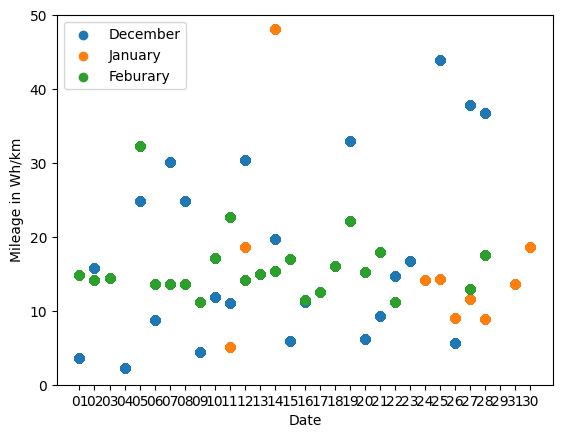

In [101]:
for i in (ThreeMonth.df['Month'].unique()):
    plt.scatter(ThreeMonth.df['date'][(ThreeMonth.df['mileage']!=-1)&(ThreeMonth.df['Month']==i)].map(indexDates),ThreeMonth.df['mileage'][(ThreeMonth.df['mileage']!=-1)&(ThreeMonth.df['Month']==i)])
plt.ylim(0,200)
plt.ylabel('Mileage in Wh/km')
plt.xlabel('Date')
plt.ylim(0,50)
plt.legend(ThreeMonth.df['Month'].unique())
plt.show()

In [102]:
print(len(ThreeMonth.Speeds),len(ThreeMonth.MileageArray))
print(OneMonth.Speeds.size,OneMonth.MileageArray.size)

74 74
25 25


In [103]:
Minerror=0
Deg=2
for i in range(2,5):
    z=BestFitFunction[i][0]
    function=np.poly1d(z)
    y=np.array([])
    for j in ThreeMonth.Speeds:
        y=np.append(y,function(j))
    error=mean_squared_error(ThreeMonth.MileageArray,y)
    if(i==2):
        Minerror=error
    elif Minerror>error:
        Minerror=error
        Deg=i
print(Deg)

4


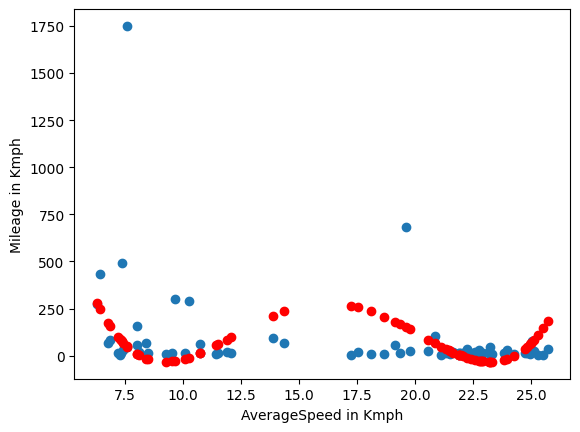

In [104]:
z=BestFitFunction[Deg][0]
function=np.poly1d(z)
y=np.array([])
for j in ThreeMonth.Speeds:
    y=np.append(y,function(j))
plt.scatter(ThreeMonth.Speeds,ThreeMonth.MileageArray)
plt.scatter(ThreeMonth.Speeds,y,color='red')
plt.xlabel('AverageSpeed in Kmph')
plt.ylabel('Mileage in Kmph')
plt.show()

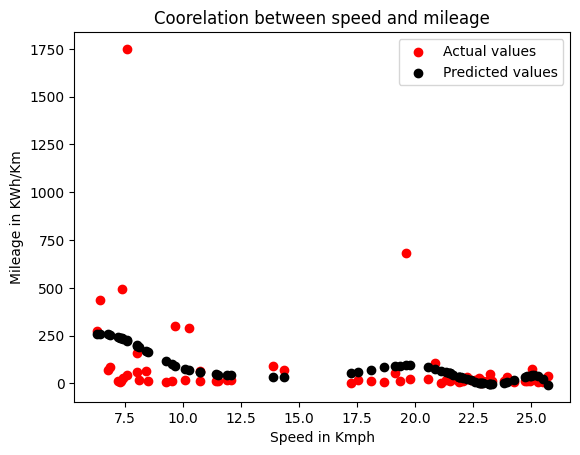

In [105]:
BestFitFunction={}# Dict(key=deg, value=[functionvalues])
minimum=0
degree=2
for i in range(2,10):
    z=np.polyfit(ThreeMonth.Speeds,ThreeMonth.MileageArray,deg=i)
    x=np.poly1d(z)
    y=np.array([])
    for j in ThreeMonth.Speeds:
        y=np.append(y,x(j))
    error=mean_squared_error(ThreeMonth.MileageArray,y)
    #print(error,end="*")
    match i:
        case 2:
            min=error
            BestFitFunction[degree]=[z,y]
        case default:
            if error<min:
                #print('Reached')
                min=error
                degree=i
                BestFitFunction[degree]=[z,y]
#print(deg,error)
plt.scatter(ThreeMonth.Speeds,ThreeMonth.MileageArray,color='red')
plt.scatter(ThreeMonth.Speeds,BestFitFunction[degree][1],color='black')
plt.xlabel("Speed in Kmph")
plt.ylabel("Mileage in KWh/Km")
plt.legend(['Actual values','Predicted values'])
plt.title('Coorelation between speed and mileage')
plt.show()